In [1]:
# Import required libraries
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from core.backtest_orchestrator import BacktestOrchestrator
from signals.momentum import MomentumSignalV2

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 4)

print("✅ Imports successful")
print(f"   Project root: {project_root}")

✅ Imports successful
   Project root: /Users/Sakarias/QuantTrading


## 1. Portfolio Configuration

Define portfolio-level settings and walk-forward parameters.

In [2]:
# Portfolio Configuration
CONFIG = {
    'assets': ['ES'],  # Single asset for walk-forward (currently required)
    'total_capital': 100_000,  # $100k for optimization
    'oos_split': 0.15,  # Final OOS validation (85% optimize, 15% validate)
    'date_range': ('2020-01-01', '2024-12-31'),  # 5 years of data
}

# Walk-Forward Parameters
WF_CONFIG = {
    'train_pct': 0.70,  # 70% of each window for training
    'test_pct': 0.15,   # 15% of each window for testing
    'metric': 'sharpe',  # Optimization metric ('sharpe', 'return', 'risk_adjusted')
}

print("📋 Configuration:")
print(f"   Asset: {CONFIG['assets'][0]}")
print(f"   Capital: ${CONFIG['total_capital']:,}")
print(f"   Walk-Forward: {WF_CONFIG['train_pct']:.0%} train, {WF_CONFIG['test_pct']:.0%} test")
print(f"   Optimization Metric: {WF_CONFIG['metric'].upper()}")
print(f"   Final OOS: {CONFIG['oos_split']:.0%}")

📋 Configuration:
   Asset: ES
   Capital: $100,000
   Walk-Forward: 70% train, 15% test
   Optimization Metric: SHARPE
   Final OOS: 15%


## 2. Initialize & Load Data

In [3]:
# Initialize orchestrator
orchestrator = BacktestOrchestrator(config=CONFIG)

# Load data
orchestrator.load_data(
    tickers=CONFIG['assets'],
    start_date=CONFIG['date_range'][0],
    end_date=CONFIG['date_range'][1],
    verbose=True
)

📊 Loading data for 1 assets...

Loading 1 assets: ['ES']
  📡 CSV data is 338 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-12-04)
✓ ES: 6362 rows, 2000-09-18 to 2025-12-04

Common date range: 2000-09-18 to 2025-12-04
Filtered date range: 2020-01-01 to 2024-12-31

Total unique dates: 1259

ALIGNMENT SUMMARY
ES: 1259/1259 valid dates (100.0%)

✅ Data loaded successfully:
   ES: 1259 days (2020-01-02 to 2024-12-31)
      Price range: $2220.50 - $6099.00
  ✓ Added 228 days from yfinance (now through 2025-12-04)
✓ ES: 6362 rows, 2000-09-18 to 2025-12-04

Common date range: 2000-09-18 to 2025-12-04
Filtered date range: 2020-01-01 to 2024-12-31

Total unique dates: 1259

ALIGNMENT SUMMARY
ES: 1259/1259 valid dates (100.0%)

✅ Data loaded successfully:
   ES: 1259 days (2020-01-02 to 2024-12-31)
      Price range: $2220.50 - $6099.00


## 3. Split Data for Final OOS Validation

We'll use 85% for walk-forward optimization and hold out 15% for final validation.

In [4]:
# Split data for final OOS validation
orchestrator.split_train_test_data(oos_pct=CONFIG['oos_split'], verbose=True)

print(f"\n📊 Optimization period: {len(orchestrator.prices_train['ES'])} days")
print(f"   Final validation period: {len(orchestrator.prices_test['ES'])} days")


📊 Splitting data: 85% train, 15% OOS
  ES: 1070 train days, 189 test days
      Train: 2020-01-02 to 2024-04-02
      Test:  2024-04-03 to 2024-12-31
✅ Data split complete. Use .prices for train, .prices_test for OOS

📊 Optimization period: 1070 days
   Final validation period: 189 days


## 4. Define Parameter Grid

Specify which parameters to optimize and what values to test.

For MomentumSignalV2, key parameters are:
- **lookback**: How many days to look back for momentum calculation
- **entry_threshold**: Minimum price change to enter (optional)

**Important**: More parameters = longer optimization time!
- 2 parameters with 3 values each = 9 combinations
- 3 parameters with 4 values each = 64 combinations

In [5]:
# Define parameter grid
PARAM_GRID = {
    'lookback': [10, 20, 30, 50],  # Test 4 different lookback periods
    # 'entry_threshold': [0.01, 0.02, 0.03],  # Uncomment to optimize threshold too
}

total_combinations = np.prod([len(v) for v in PARAM_GRID.values()])
print(f"📊 Parameter Grid:")
for param, values in PARAM_GRID.items():
    print(f"   {param}: {values}")
print(f"\n   Total combinations to test: {total_combinations}")

📊 Parameter Grid:
   lookback: [10, 20, 30, 50]

   Total combinations to test: 4


## 5. Run Walk-Forward Optimization

This will:
1. Create overlapping train/test windows
2. For each window, test all parameter combinations on train data
3. Select best parameters based on optimization metric
4. Test those parameters on the OOS test data
5. Aggregate results across all periods

**Note**: This can take several minutes depending on:
- Data size
- Number of parameters
- Number of values per parameter

In [6]:
# Run walk-forward optimization
print("\n🔄 Starting walk-forward optimization...")
print("   This may take a few minutes...\n")

optimizer = orchestrator.run_walkforward(
    signal_class=MomentumSignalV2,  # Pass the CLASS, not an instance
    param_grid=PARAM_GRID,
    assets=CONFIG['assets'],
    train_pct=WF_CONFIG['train_pct'],
    test_pct=WF_CONFIG['test_pct'],
    metric=WF_CONFIG['metric'],
    initial_capital=CONFIG['total_capital'],
    verbose=True
)

print("\n✅ Walk-forward optimization complete!")


🔄 Starting walk-forward optimization...
   This may take a few minutes...


🔄 Starting walk-forward optimization for ES...
🔄 WALK-FORWARD OPTIMIZATION
Signal Class: MomentumSignalV2
Parameter Grid: {'lookback': [10, 20, 30, 50]}
Train/Test Split: 70% / 15%
Optimization Metric: SHARPE
Data: 1070 days (2020-01-02 to 2024-04-02)

📊 Generated 2 walk-forward periods



Walk-Forward Periods: 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


📊 WALK-FORWARD SUMMARY
Total Periods:        2
Average Return:       3.71%
Median Return:        3.71%
Best Period:          6.26%
Worst Period:         1.15%
Win Rate:             100.0%
Average Sharpe:       0.6554
Average Max DD:       -2.14%
Cumulative Return:    7.49%

🎯 MOST STABLE PARAMETERS
lookback: 10

✅ Walk-forward optimization complete!


## 6. Analyze Parameter Stability

Check which parameters were selected in each period.
Stable parameters (selected frequently) are more robust!


📊 Parameter Selection by Period:
 Period  lookback
      1        10
      2        10


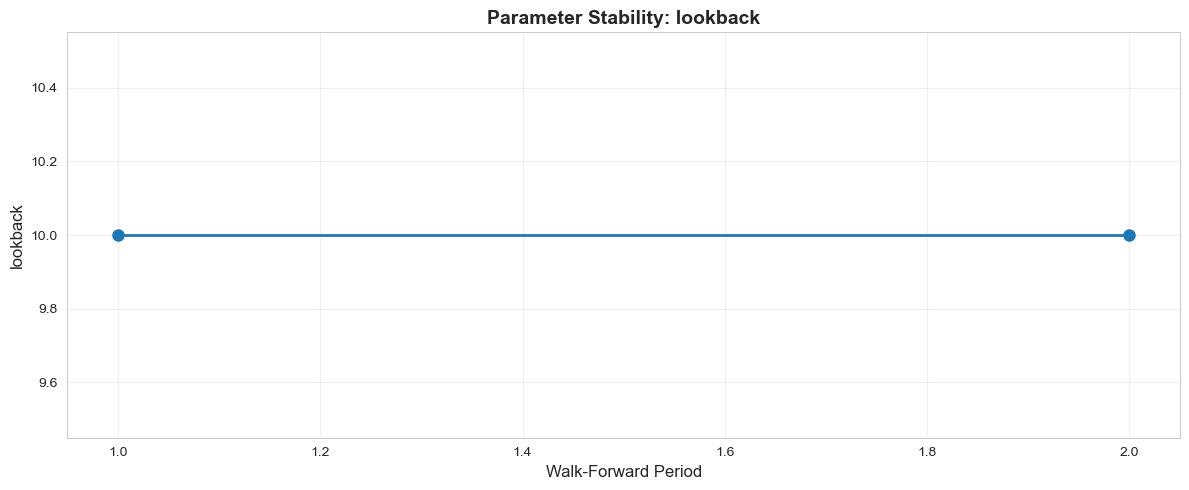

In [14]:
# Get parameter stability across periods
stability_df = optimizer.get_parameter_stability()

print("\n📊 Parameter Selection by Period:")
print(stability_df.to_string(index=False))

# Visualize parameter stability
if len(PARAM_GRID) == 1:
    param_name = list(PARAM_GRID.keys())[0]
    
    plt.figure(figsize=(12, 5))
    plt.plot(stability_df['Period'], stability_df[param_name], marker='o', linewidth=2, markersize=8)
    plt.xlabel('Walk-Forward Period', fontsize=12)
    plt.ylabel(param_name, fontsize=12)
    plt.title(f'Parameter Stability: {param_name}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Get Most Stable Parameters

Find the parameters that were selected most frequently across periods.

In [15]:
# Get best (most stable) parameters
best_params = optimizer.get_best_params()

print("\n🎯 Most Stable Parameters:")
for param, value in best_params.items():
    print(f"   {param}: {value}")

# Count how often each value was selected
for param_name in PARAM_GRID.keys():
    param_values = stability_df[param_name].value_counts().sort_index()
    print(f"\n   {param_name} selection frequency:")
    for value, count in param_values.items():
        pct = (count / len(stability_df)) * 100
        print(f"      {value}: {count}/{len(stability_df)} periods ({pct:.1f}%)")


🎯 Most Stable Parameters:
   lookback: 10

   lookback selection frequency:
      10: 2/2 periods (100.0%)


## 8. Walk-Forward Summary Statistics

Analyze performance across all walk-forward periods.

In [16]:
# Get summary statistics
stats = optimizer.get_summary_statistics()

print("\n" + "="*80)
print("📊 WALK-FORWARD SUMMARY STATISTICS")
print("="*80)
print(f"Total Periods:        {stats['num_periods']}")
print(f"Average OOS Return:   {stats['avg_return']:.2%}")
print(f"Median OOS Return:    {stats['median_return']:.2%}")
print(f"Std Dev of Returns:   {stats['std_return']:.2%}")
print(f"Best Period:          {stats['best_return']:.2%}")
print(f"Worst Period:         {stats['worst_return']:.2%}")
print(f"Win Rate:             {stats['win_rate']:.1%}")
print(f"Average Sharpe:       {stats['avg_sharpe']:.4f}")
print(f"Average Max DD:       {stats['avg_max_drawdown']:.2%}")
print(f"Cumulative Return:    {stats['total_return']:.2%}")
print("="*80)


📊 WALK-FORWARD SUMMARY STATISTICS
Total Periods:        2
Average OOS Return:   3.71%
Median OOS Return:    3.71%
Std Dev of Returns:   2.55%
Best Period:          6.26%
Worst Period:         1.15%
Win Rate:             100.0%
Average Sharpe:       0.6554
Average Max DD:       -2.14%
Cumulative Return:    7.49%


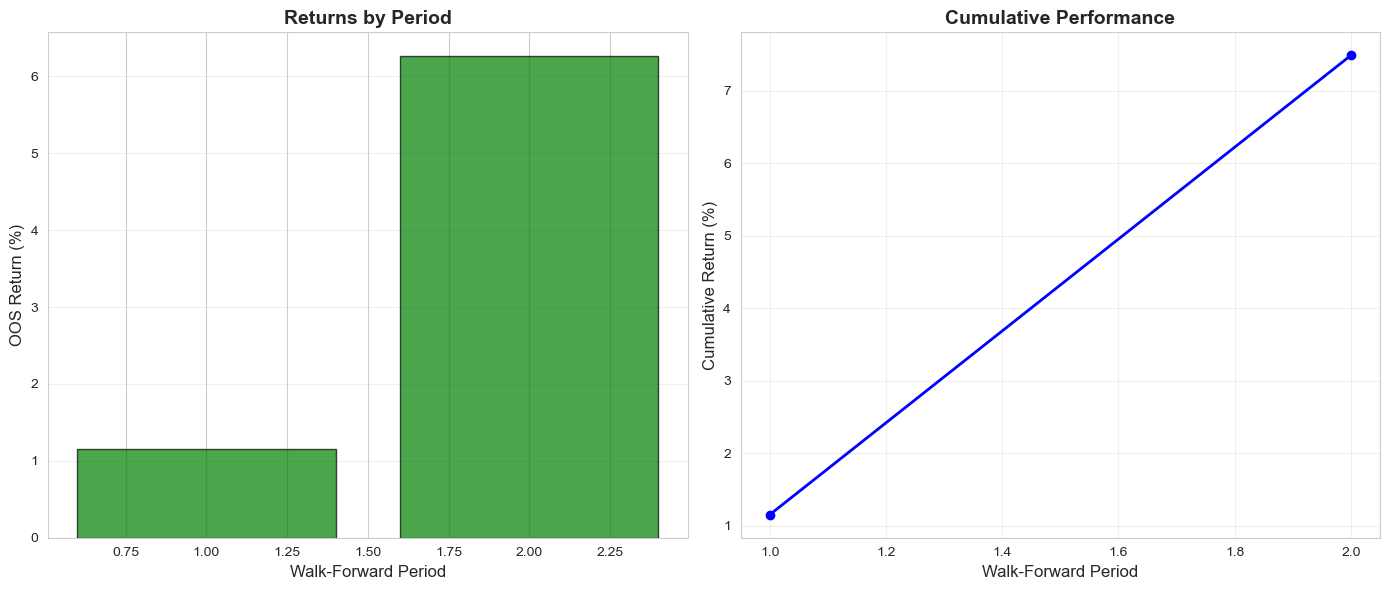

In [17]:
# Visualize walk-forward period returns
period_returns = [p.test_return * 100 for p in optimizer.periods]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(period_returns) + 1), period_returns, 
        color=['green' if r > 0 else 'red' for r in period_returns],
        alpha=0.7, edgecolor='black')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Walk-Forward Period', fontsize=12)
plt.ylabel('OOS Return (%)', fontsize=12)
plt.title('Returns by Period', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 2, 2)
cumulative_return = np.cumprod([1 + r/100 for r in period_returns]) - 1
plt.plot(range(1, len(cumulative_return) + 1), cumulative_return * 100, 
         marker='o', linewidth=2, markersize=6, color='blue')
plt.xlabel('Walk-Forward Period', fontsize=12)
plt.ylabel('Cumulative Return (%)', fontsize=12)
plt.title('Cumulative Performance', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Run Final OOS Backtest with Best Parameters

Now test the optimized parameters on the final held-out validation data.

In [18]:
# Create signal generator with best parameters
optimized_signal = MomentumSignalV2(**best_params)

print(f"\n🎯 Testing optimized parameters on final OOS period...")
print(f"   Parameters: {best_params}")

# Add strategy with optimized parameters
orchestrator.add_strategy(
    name='Optimized_Strategy',
    signal_generator=optimized_signal,
    assets=CONFIG['assets'],
    capital=CONFIG['total_capital'],
    position_sizer_type='fixed',
    risk_per_trade=0.02
)

# Generate signals and run OOS backtest
orchestrator.generate_signals(verbose=False)
orchestrator.run_backtests(verbose=False)
final_oos_results = orchestrator.run_oos_backtest(verbose=True)


🎯 Testing optimized parameters on final OOS period...
   Parameters: {'lookback': 10}

🎯 Running OUT-OF-SAMPLE backtests...

  Optimized_Strategy - Generating OOS signals...

  Optimized_Strategy - Generating OOS signals...

  Optimized_Strategy ($100,000)...
    ✅ OOS Return: 2.39%
    📊 OOS Sharpe: 0.18
    📉 OOS Max DD: -4.18%

  Optimized_Strategy ($100,000)...
    ✅ OOS Return: 2.39%
    📊 OOS Sharpe: 0.18
    📉 OOS Max DD: -4.18%

✅ OOS backtests completed


## 10. Compare Results

Compare walk-forward average vs final OOS performance.

In [19]:
# Get final OOS metrics
final_result = final_oos_results['Optimized_Strategy']['result']

print("\n" + "="*80)
print("📊 PERFORMANCE COMPARISON")
print("="*80)
print(f"\nWalk-Forward Average (optimization periods):")
print(f"   Average Return:    {stats['avg_return']:>8.2%}")
print(f"   Median Return:     {stats['median_return']:>8.2%}")
print(f"   Average Sharpe:    {stats['avg_sharpe']:>8.2f}")
print(f"   Win Rate:          {stats['win_rate']:>8.1%}")

print(f"\nFinal OOS (held-out validation period):")
print(f"   Return:            {final_result.total_return:>8.2%}")
print(f"   Sharpe:            {final_result.metrics['Sharpe Ratio']:>8.2f}")
print(f"   Max Drawdown:      {final_result.metrics['Max Drawdown']:>8.2%}")
print(f"   Total Trades:      {final_result.metrics['Total Trades']:>8.0f}")

# Calculate consistency
consistency = (final_result.total_return / stats['avg_return']) if stats['avg_return'] != 0 else 0
print(f"\nConsistency Ratio:   {consistency:>8.2f}x")
if abs(consistency - 1.0) < 0.3:
    print("   ✅ Good consistency between optimization and validation!")
elif consistency < 0.7:
    print("   ⚠️  Final OOS underperforms - possible overfitting")
else:
    print("   ⚠️  Final OOS significantly different - check for regime changes")

print("="*80)


📊 PERFORMANCE COMPARISON

Walk-Forward Average (optimization periods):
   Average Return:       3.71%
   Median Return:        3.71%
   Average Sharpe:        0.66
   Win Rate:            100.0%

Final OOS (held-out validation period):
   Return:               2.39%
   Sharpe:                0.18
   Max Drawdown:        -4.18%
   Total Trades:             0

Consistency Ratio:       0.65x
   ⚠️  Final OOS underperforms - possible overfitting


## 11. Export Results

Generate HTML dashboard with all results.

In [20]:
# Export comprehensive dashboard
filepath = orchestrator.export_html_dashboard(
    output_dir='results/html',
    filename_prefix='walkforward',
    include_oos=True
)

print(f"\n✅ Dashboard exported to: {filepath}")

# Also save walk-forward summary to CSV
wf_summary = pd.DataFrame([{
    'periods': stats['num_periods'],
    'avg_return': stats['avg_return'],
    'median_return': stats['median_return'],
    'best_return': stats['best_return'],
    'worst_return': stats['worst_return'],
    'win_rate': stats['win_rate'],
    'avg_sharpe': stats['avg_sharpe'],
    'cumulative_return': stats['total_return'],
    'final_oos_return': final_result.total_return,
    'best_params': str(best_params)
}])

# Create CSV directory if it doesn't exist
csv_dir = Path('results/csv')
csv_dir.mkdir(parents=True, exist_ok=True)

csv_path = csv_dir / f"walkforward_{pd.Timestamp.now().strftime('%Y-%m-%d')}.csv"
wf_summary.to_csv(csv_path, index=False)
print(f"   Summary saved to: {csv_path}")


💾 HTML dashboard saved: results/html/walkforward_2025-12-04.html

✅ Dashboard exported to: results/html/walkforward_2025-12-04.html
   Summary saved to: results/csv/walkforward_2025-12-04.csv


## 12. Interpretation & Next Steps

### What to Look For:

**Good Signs:**
- ✅ Positive returns in 60%+ of walk-forward periods
- ✅ Final OOS within 70-130% of walk-forward average
- ✅ Consistent parameter selection across periods
- ✅ Average Sharpe > 0.5

**Red Flags:**
- ⚠️ Win rate < 50% across periods
- ⚠️ Final OOS much worse than walk-forward average
- ⚠️ Parameters change drastically each period (unstable)
- ⚠️ Negative cumulative return

### Parameter Stability Matters!

If the "best" parameters keep changing every period:
- Strategy might be curve-fit to noise
- Consider simpler signals
- Use fewer parameters
- Test on longer periods

### Next Steps:

1. **If results are strong:** Test on more recent data or paper trade
2. **If results are weak:** Try different signals or parameter ranges
3. **Before going live:** 
   - Test on other assets
   - Check performance in different market conditions
   - Always paper trade first!

### Advanced Topics:

- **Anchored Walk-Forward**: Use expanding window instead of rolling
- **Multiple Assets**: Optimize each asset separately
- **Risk-Adjusted**: Optimize for Sharpe or risk-adjusted metrics
- **Ensemble**: Combine multiple parameter sets

Happy optimizing! 🚀

## Additional Notes

This template demonstrates:
- ✅ Walk-forward parameter optimization
- ✅ Multiple rolling windows across different regimes
- ✅ Parameter stability analysis
- ✅ Final OOS validation on held-out data
- ✅ Comprehensive result export

**Key Takeaway**: Walk-forward optimization helps you find parameters that work across different market conditions, not just the specific period you tested on. This significantly reduces overfitting risk!

Remember: Past performance doesn't guarantee future results. Always validate thoroughly before risking capital.